In [10]:
high_v = 70
low_v = 10
mid_v = 35

half_cycle_length = 64

H = high_v * np.ones(240)
L = low_v * np.ones(240)

D = np.linspace(high_v, low_v, half_cycle_length)
A = np.linspace(low_v, high_v, half_cycle_length)
select = 4
if select==1:
    test_signal = np.concatenate((H,D,A,H), axis=0)
if select==2:
    test_signal = np.concatenate((H, D, A, D, A, H), axis=0)
if select==3:
    test_signal = np.concatenate((L,A,D,H), axis=0)
if select==4:
    test_signal = np.concatenate((L, A, D, A, H), axis=0)

t = np.arange(0,len(test_signal))


In [11]:
def wvlt_ener(x):
    a = np.arange(1,64.1,0.1)
    coef, _t=pywt.cwt(x,a,'mexh')
    coef = coef.clip(min=0)
    E = (1/64) * np.sum(np.square(np.abs(coef)), axis=0)
    return E


In [12]:
import numpy as np
from utils import  wvlt_ener, peak_classify
import matplotlib.pyplot as plt
import scipy.io as sio
import pywt
from scipy import signal


ImportError: cannot import name 'wvlt_ener'

In [13]:
from utils import  wvlt_energy, peak_classify


ImportError: cannot import name 'wvlt_energy'

In [14]:
import numpy as np
import pywt
import pandas as pd


In [15]:
from utils_p import  wvlt_ener, peak_classify


ModuleNotFoundError: No module named 'utils_p'

In [16]:
from utils_p import  wvlt_ener, peak_classify


ModuleNotFoundError: No module named 'utils_p'

In [17]:
from keidi import  wvlt_ener, peak_classify


ModuleNotFoundError: No module named 'keidi'

In [18]:
# -*- coding: utf-8 -*-
"""

Collection of functions used in the main.py
@author: Keidi Kapllani
"""

import numpy as np
import pywt
import pandas as pd


#%%
def load_data(cntrl,force_recalc):
    print('LOG: Loading data ')
    '''
    Function to load data and perform smoothing and denoising. This function stores the processed data.
    If a saved array exist, it loads from that array. 
    INPUT: cntrl: Select which time-group to load (0,1,2)
           force_recalc: Forces recalculation from original dataset
           
    OUTPUT: data_smooth: Smooth and denoised data
    '''

    data = ['1','2', '3'] 
    #columns to keep for working data
    keep = [0,3,6,10,11,13,16]
    
    try:
        if force_recalc:
            raise UnboundLocalError('Forcing smoothing for original data')
        file_name = 'data_'+data[cntrl]+'_smoooth_de.npy'
        data_smooth = np.load(file_name)
        file_name = 'data_'+data[cntrl]+'_raw.npy'
        data_raw = np.load(file_name)
        print('LOG: Data loaded from pre-processed arrays ')
        
    except:
        print('LOG: Peforming smoothing & denoising on data ')
        if cntrl == 0:
            data_first  = pd.read_csv('data/0750am-0805am/trajectories-0750am-0805am.txt', delim_whitespace=True, header=None)
            timestamp = pd.to_datetime(data_first[3],unit='ms')
            data_first[3] = time_fix(timestamp)
            data_raw = data_first.values 
            data_raw = data_raw[:,keep]
            data_raw[:,2] = data_raw[:,2]* 0.0003048  #convert position data to km
            data_raw[:,6] = data_raw[:,6]* 0.0003048  #convert space data to km
            data_raw[:,4] = data_raw[:,4]* 1.09728  #convert space data to km
            data_ext = np.zeros((data_raw.shape[0],8))
            data_ext[:,:-1] = data_raw
            data_smooth= smooth_data(data_ext)
            np.save( 'data_'+data[cntrl]+'_smoooth_de',data_smooth)
            np.save( 'data_'+data[cntrl]+'_raw',data_raw)
            
        #Second time-group    
        elif cntrl==1:
            data_second = pd.read_csv('data/0805am-0820am/trajectories-0805am-0820am.txt', delim_whitespace=True, header=None)
            timestamp = pd.to_datetime(data_second[3],unit='ms')
            data_second[3] = time_fix(timestamp)
            data_raw = data_second.values 
            data_raw = data_raw[:,keep]
            data_raw[:,2] = data_raw[:,2]* 0.0003048  #convert to km
            data_raw[:,6] = data_raw[:,6]* 0.0003048  #convert space data to km
            data_raw[:,4] = data_raw[:,4]* 1.09728  #convert space data to km
            data_ext = np.zeros((data_raw.shape[0],8))
            data_ext[:,:-1] = data_raw
            data_smooth = smooth_data(data_ext)
            np.save( 'data_'+data[cntrl]+'_smoooth_de',data_smooth)
            np.save( 'data_'+data[cntrl]+'_raw',data_raw)
        #Third time-group    
        elif cntrl==2:
            data_third  = pd.read_csv('data/0820am-0835am/trajectories-0820am-0835am.txt', delim_whitespace=True, header=None)
            timestamp = pd.to_datetime(data_third[3],unit='ms')
            data_third[3] = time_fix(timestamp)
            data_raw = data_third.values 
            data_raw = data_raw[:,keep]
            data_raw[:,2] = data_raw[:,2]* 0.0003048  #convert to km
            data_raw[:,6] = data_raw[:,6]* 0.0003048  #convert space data to km
            data_raw[:,4] = data_raw[:,4]* 1.09728  #convert space data to km
            data_ext = np.zeros((data_raw.shape[0],8))
            data_ext[:,:-1] = data_raw
            data_smooth = smooth_data(data_ext)
            np.save( 'data_'+data[cntrl]+'_smoooth_de',data_smooth)
            np.save( 'data_'+data[cntrl]+'_raw',data_raw)
            
    
    print('LOG: Done')
    return data_smooth, data_raw





#%%
def diff_v_a(x_in,dt):
# Perform numerical derivative to estimate instantenous velocity from poistion data. 
    
    N = np.shape(x_in)
    vel = np.zeros(N[0])
    for i in range(1,N[0]-1):
        vel[i-1] = (x_in[i+1]-x_in[i-1])/(2*dt)
        
    vel = vel[:N[0]-2]    
    return vel

#%%

def sema_smoothing(x_in,dt,T):
    delta = T/dt
    N = np.shape(x_in)
    x_out = np.zeros(N[0])
    for i in range(1,N[0]+1):
        D = int(min(3*delta,i-1,N[0]-i))
        k = np.arange(i-D,i+D+1)
        p = -np.abs(i-k)/delta
        exx = np.exp(p)
        Z = np.sum(exx)
        xa = x_in[k-1]
        x_out[i-1] = (1/Z) * np.sum(xa.T*exx)
    return x_out

#%%
' Calculate the wavelet energy for a signal x'    
def wvlt_ener(x):
    a = np.arange(1,64.1,0.1)
    coef, _t=pywt.cwt(x,a,'mexh')
    coef = coef.clip(min=0)
    E = (1/64) * np.sum(np.square(np.abs(coef)), axis=0)
    return E

#%%
    'Performs smoothing and wavelet denoising on data'
def smooth_data(data):
    print('Smoothing and Denoising')
    car_id_list = np.unique(data[:,0]).astype(int)
   
    dt = 0.1/3600; # data point time interval
    Tx = 0.5/3600; # smoothing width (position data)
    Tv = 1/3600; # smoothing width (velocity data)   
    
    for i in range(0,car_id_list.size):
        idx = np.where(data[:,0]==car_id_list[i])[0]
        pos = data[idx,2]
        pos1 = sema_smoothing(pos,dt,Tx)
        vel_dif = diff_v_a(pos1,dt)
        vel_smooth = sema_smoothing(vel_dif,dt,Tv)
        dwt_vel = denoise(data[idx,4])
        vel = np.insert( vel_smooth, 0, 0)
        vel = np.append( vel, 0)
        data[idx,2] = pos1
        data[idx,4] = vel
        data[idx,7] = dwt_vel
    return data
#%%

def wrcoef(X, coef_type, coeffs, wavename, level):
    N = np.array(X).size
    a, ds = coeffs[0], list(reversed(coeffs[1:]))

    if coef_type =='a':
        return pywt.upcoef('a', a, wavename, level=level)[:N]
    elif coef_type == 'd':
        return pywt.upcoef('d', ds[level-1], wavename, level=level)[:N]
    else:
        raise ValueError("Invalid coefficient type: {}".format(coef_type))

#%%
def denoise(data):
    lvl = 4
    db4 = pywt.Wavelet('db4')
#    coeffs=pywt.wavedec(data, db4, level=lvl)
    C, L = wavedec1(data, wavelet=db4, level=lvl)
#    n = data.size
#    cA6cD_approx = pywt.waverec(coeffs, 'db4',axis = 0)
    D = wrcoef1(C, L, wavelet=db4, level=4)
#    (cA, cD) = pywt.dwt(data, 'db4')
#    smotheed = pywt.waverec()
    return D

#%%
def lane_changer(lane_data):
    """
    identify lane changers and return car ids of lane changers and non-lane changers
    INPUT: lane_data: Full data in the forma nx7
           
    OUTPUT: lane_normal: Car ids of non-lane changers
            lane_changers: Car ids of lane changers
    """
    lane_changers = []
    lane_normal = []
    car_id_list = np.unique(lane_data[:,0]).astype(int)
    for i in range(0,car_id_list.size):
        car = lane_data[np.where(lane_data[:,0]==car_id_list[i])]
        lanes = np.unique(car[:,5])
        if lanes.size == 1:
            lane_normal.append(car_id_list[i])
        else:
            lane_changers.append(car_id_list[i])
        
    return lane_normal, lane_changers    

#%%%
def peak_classify(locs_p, locs_n, v):
    """
    Classify peaks into Acceleration (A), Decceleration (D) or Steade-state (S)
    INPUT: locs_p: location of peaks in positive wave
           locs_n: locaiton of peaks in negative wave
           v:      velocity data
    OUTPUT: locs_sort: Index of peaks classified
            info_sort: Peak information; 0 - Decceleration (D) , 1-Acceleration (A), 3-Steade-state (S)
    """
    locs_pn = np.append(locs_p,locs_n)
    info = np.append(np.ones(locs_p.size),np.zeros(locs_n.size))
    locs_sort = np.sort(locs_pn)
    info_sort = info[np.argsort(locs_pn)]
    if locs_sort.size>0:
#        for i in range(0,locs_sort.size-1):
#            if (abs(v[locs_sort[i]]-v[locs_sort[i]+50]) and abs(v[locs_sort[i]]-v[locs_sort[i]-50]) )<4:
#                info_sort[i] = 2
#        
        if locs_sort[locs_sort.size-1] > v.size-64:
            locs_sort = locs_sort[:-1]
            info_sort = info_sort[:-1]
        if locs_sort[0] < 51:
            locs_sort = locs_sort[1:]
            info_sort = info_sort[1:]
    
        
    return locs_sort, info_sort
#%%%
def time_fix(timestamp):
    """
    Convert pandas timestamp into hours represenation
    INPUT: timestamp: pandas timestamp data
    OUTPUT: t_fixed: Time data in hours
    """
    hour = timestamp.dt.hour.values - 7
    minutes = timestamp.dt.minute.values
    seconds = timestamp.dt.second.values
    ms = timestamp.dt.microsecond.values/1e6
    t_fixed = hour + np.round((((seconds+ms)/60)+minutes)/60,4)
    
    return t_fixed

#%%
def clust_assign(t_new, x_new, cid_new, t, x, cid):
    
    time_flag = False;
    id_flag = False;
    space_flag = False;
    
    'Check if the time difference is between 0.9 - 1 sec'
    time_diff = t_new - t
    if (time_diff  > -5/3600 and time_diff < 10/3600):
        time_flag = True
        
    'check if ther are differnt cars'
    if cid_new > cid:
        id_flag = True
    'Check if the space is more then 50m'
    if x_new - x < 0.5:
        space_flag = True
    
    
    if (time_flag and id_flag and space_flag):
        cluster_flag = True
    else:
        cluster_flag = False
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    


In [19]:
high_v = 70
low_v = 10
mid_v = 35

half_cycle_length = 64

H = high_v * np.ones(240)
L = low_v * np.ones(240)

D = np.linspace(high_v, low_v, half_cycle_length)
A = np.linspace(low_v, high_v, half_cycle_length)
select = 4
if select==1:
    test_signal = np.concatenate((H,D,A,H), axis=0)
if select==2:
    test_signal = np.concatenate((H, D, A, D, A, H), axis=0)
if select==3:
    test_signal = np.concatenate((L,A,D,H), axis=0)
if select==4:
    test_signal = np.concatenate((L, A, D, A, H), axis=0)

t = np.arange(0,len(test_signal))


In [20]:
#% ---------------------- The fixed a, b -----------------------------%
a = 32
coef, _t=pywt.cwt(test_signal,a,'mexh')
E = (1/32) * np.sum(np.square(np.abs(coef)), axis=0)

thresh = 0.3e4
locs, _d = signal.find_peaks(E,height=thresh)

t_simple = t[locs]

#% ---------------------- The original method -----------------------------%

e_p_original = wvlt_ener(test_signal)
locs1, _d = signal.find_peaks(e_p_original, height=thresh)

t_original= t[locs1]
#% ------------------------ E1 & E2 method --------------------------------%
test_sign_n = np.max(test_signal) - test_signal

e_p = wvlt_ener(test_signal)
e_n = wvlt_ener(test_sign_n)

locs_p, _d = signal.find_peaks(e_p,height=thresh)
locs_n, _d = signal.find_peaks(e_n,height=thresh)

t_p = t[locs_p]
t_n = t[locs_n]

#% ---------- The complete process (with edge effect reduction------------ %

zr = np.ones(240,)*test_signal[test_signal.size-1]
test_signal_ext = np.append(test_signal,zr)
zr = np.ones(240,)*test_signal[0]
test_signal_ext = np.insert( test_signal_ext, 0, zr)
test_sign_n = np.max(test_signal_ext) - test_signal_ext


e_p_full = wvlt_ener(test_signal_ext)
e_n_full = wvlt_ener(test_sign_n)
#remove extended data
e_p_full = e_p_full[304:-304]
e_n_full = e_n_full[304:-304]
#find peaks and classify data
locs_p, _d = signal.find_peaks(e_p_full,height=thresh)
locs_n, _d = signal.find_peaks(e_n_full,height=thresh)
locs, info = peak_classify(locs_p, locs_n,test_signal[64:-64])

t_er = t[64:-64]
t_final = t_er[locs_p]
t_final_n = t_er[locs_n]


NameError: name 'signal' is not defined

In [21]:
import matplotlib.pyplot as plt
import scipy.io as sio
import pywt
from scipy import signal


In [22]:
#% ---------------------- The fixed a, b -----------------------------%
a = 32
coef, _t=pywt.cwt(test_signal,a,'mexh')
E = (1/32) * np.sum(np.square(np.abs(coef)), axis=0)

thresh = 0.3e4
locs, _d = signal.find_peaks(E,height=thresh)

t_simple = t[locs]

#% ---------------------- The original method -----------------------------%

e_p_original = wvlt_ener(test_signal)
locs1, _d = signal.find_peaks(e_p_original, height=thresh)

t_original= t[locs1]
#% ------------------------ E1 & E2 method --------------------------------%
test_sign_n = np.max(test_signal) - test_signal

e_p = wvlt_ener(test_signal)
e_n = wvlt_ener(test_sign_n)

locs_p, _d = signal.find_peaks(e_p,height=thresh)
locs_n, _d = signal.find_peaks(e_n,height=thresh)

t_p = t[locs_p]
t_n = t[locs_n]

#% ---------- The complete process (with edge effect reduction------------ %

zr = np.ones(240,)*test_signal[test_signal.size-1]
test_signal_ext = np.append(test_signal,zr)
zr = np.ones(240,)*test_signal[0]
test_signal_ext = np.insert( test_signal_ext, 0, zr)
test_sign_n = np.max(test_signal_ext) - test_signal_ext


e_p_full = wvlt_ener(test_signal_ext)
e_n_full = wvlt_ener(test_sign_n)
#remove extended data
e_p_full = e_p_full[304:-304]
e_n_full = e_n_full[304:-304]
#find peaks and classify data
locs_p, _d = signal.find_peaks(e_p_full,height=thresh)
locs_n, _d = signal.find_peaks(e_n_full,height=thresh)
locs, info = peak_classify(locs_p, locs_n,test_signal[64:-64])

t_er = t[64:-64]
t_final = t_er[locs_p]
t_final_n = t_er[locs_n]


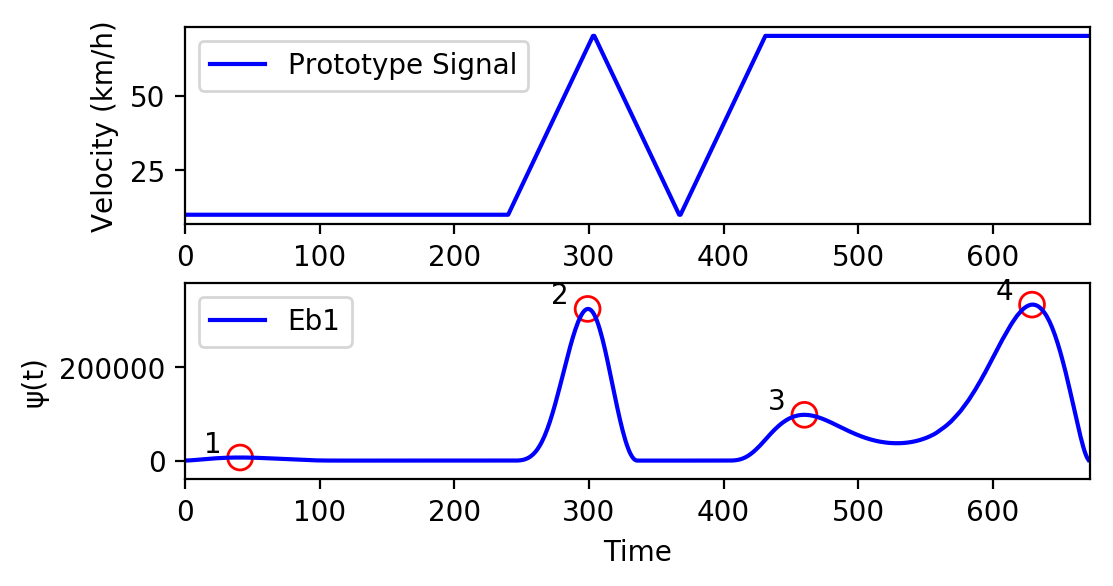

In [23]:
fig, ax = plt.subplots(2, 1,gridspec_kw={'hspace': 0.3, 'wspace': 0.3},figsize=(5,2.5))

ax[0].plot(t,test_signal,'b', linewidth=1.5,label='Prototype Signal')
ax[0].set(ylabel='Velocity (km/h)', )
ax[0].set_xlim(0, len(test_signal))
ax[0].legend()

ax[1].plot(t,e_p_original,'b', linewidth=1.5,label='Eb1')
n = np.arange(1,len(t_original)+1)
ax[1].scatter(t_original,e_p_original[t_original], s=80, facecolors='none', edgecolors='r')
ax[1].set(ylabel='ψ(t)', xlabel='Time')
ax[1].set_xlim(0,  len(t))
ax[1].legend()
for i, txt in enumerate(n):
    ax[1].annotate(txt, (t_original[i],e_p_original[t_original[i]]),textcoords="offset points", # how to position the text
                 xytext=(-10,2), # distance from text to points (x,y)
                 ha='center')

fig.set_dpi(200)
plt.subplots_adjust(top=0.99,
                    bottom=0.085,
                    left=0.085,
                    right=0.99,
                    hspace=0.2,
                    wspace=0.2)


In [24]:
plt.savefig('prot_sign_norm.png')


PermissionError: [Errno 13] Permission denied: 'prot_sign_norm.png'

<Figure size 432x288 with 0 Axes>

PermissionError: [Errno 13] Permission denied: 'prot_sign_norm.png'

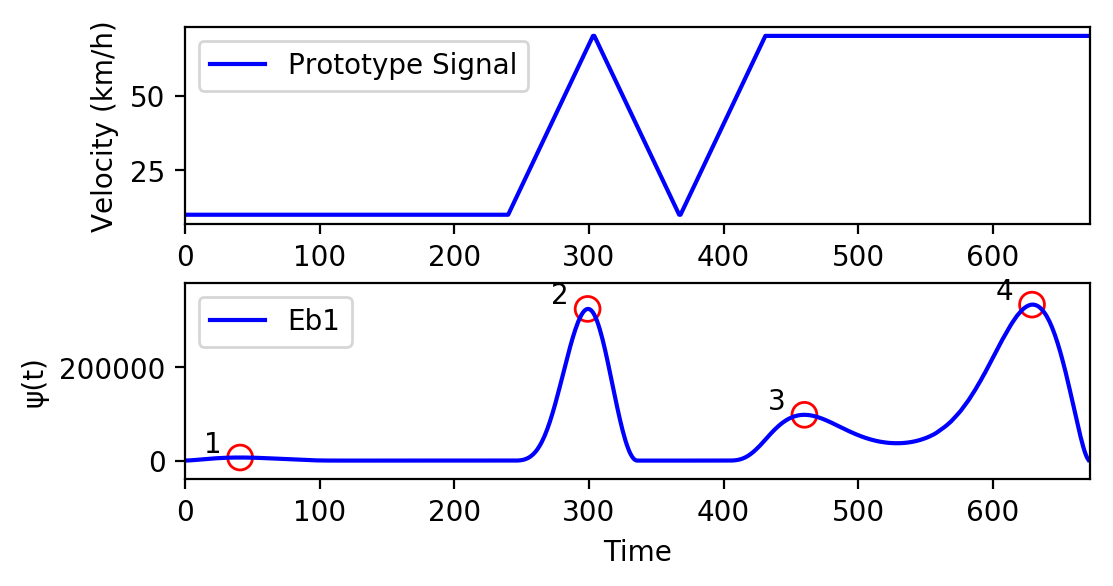

In [25]:
fig, ax = plt.subplots(2, 1,gridspec_kw={'hspace': 0.3, 'wspace': 0.3},figsize=(5,2.5))

ax[0].plot(t,test_signal,'b', linewidth=1.5,label='Prototype Signal')
ax[0].set(ylabel='Velocity (km/h)', )
ax[0].set_xlim(0, len(test_signal))
ax[0].legend()

ax[1].plot(t,e_p_original,'b', linewidth=1.5,label='Eb1')
n = np.arange(1,len(t_original)+1)
ax[1].scatter(t_original,e_p_original[t_original], s=80, facecolors='none', edgecolors='r')
ax[1].set(ylabel='ψ(t)', xlabel='Time')
ax[1].set_xlim(0,  len(t))
ax[1].legend()
for i, txt in enumerate(n):
    ax[1].annotate(txt, (t_original[i],e_p_original[t_original[i]]),textcoords="offset points", # how to position the text
                 xytext=(-10,2), # distance from text to points (x,y)
                 ha='center')

fig.set_dpi(200)
plt.subplots_adjust(top=0.99,
                    bottom=0.085,
                    left=0.085,
                    right=0.99,
                    hspace=0.2,
                    wspace=0.2)
plt.savefig('prot_sign_norm.png')
